In [27]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import torch
import dolfin
from dolfin import *
from mshr import *

num = 11
domain = Rectangle(Point(-1,-1), Point(3,1)) - Circle(Point(0,0), 0.5)
mesh = generate_mesh(domain, num)

V = VectorElement('CG', triangle, 2)
Q = FiniteElement('CG', triangle, 1)
TH = V * Q
W = FunctionSpace(mesh, TH)

x_c, y_c = 0.0, 0.0  
class Circle(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0]-x_c)**2 + (x[1]-y_c)**2 < 0.5**2
    
facet_marker = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
Circle().mark(facet_marker, 2)

# Define boundary conditions
u_inflow = Expression(("1 - x[1]*x[1]", "0"), degree=1)
noslip = DirichletBC(W.sub(0), (0, 0), "on_boundary && (x[1] >= 0.9 || x[1] < 0.1)")

inflow = DirichletBC(W.sub(0), u_inflow, "on_boundary && x[0] <= 0.1")
circle = DirichletBC(W.sub(0), (0, 0), facet_marker, 2)
outflow = DirichletBC(W.sub(1), 0, "on_boundary && x[0] >= 0.9")
bcs = [noslip, inflow, outflow, circle]

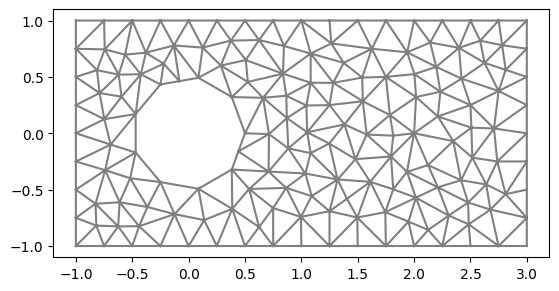

In [28]:
plot(mesh)

In [29]:
V_vel = W.sub(0).collapse()

In [30]:
from dolfin import *

phi = TrialFunction(V_vel)
psi = TestFunction(V_vel)

# B1: x-component of convective derivative
B1_form = dot(phi, grad(psi))[0] * dx
B1 = assemble(B1_form)

# B2: y-component of convective derivative
B2_form = dot(phi, grad(psi))[1] * dx
B2 = assemble(B2_form)

# Convert to NumPy arrays if needed:
B1_mat = B1.array()
B2_mat = B2.array()

### Fenics solution

In [31]:
w = Function(W)
(u, p) = split(w)
(v, q) = TestFunctions(W)
nu = Constant(0.1)
f = Constant((0, 0))

F = (
    nu * inner(grad(u), grad(v)) * dx
    + inner(dot(u, nabla_grad(u)), v) * dx
    - div(v) * p * dx
    - q * div(u) * dx
    - inner(f, v) * dx
)

# Solve nonlinearly
solve(F == 0, w, bcs, solver_parameters={"newton_solver": {"linear_solver": "mumps"}})

# Split solution
u_sol, p_sol = w.split()

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.051e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.593e-01 (tol = 1.000e-10) r (rel) = 1.760e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.725e-03 (tol = 1.000e-10) r (rel) = 3.010e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 4.191e-07 (tol = 1.000e-10) r (rel) = 4.631e-08 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.944e-14 (tol = 1.000e-10) r (rel) = 6.567e-15 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.


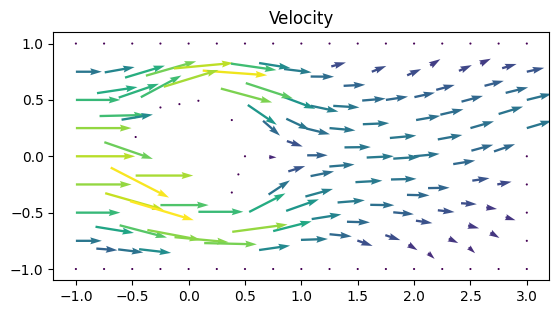

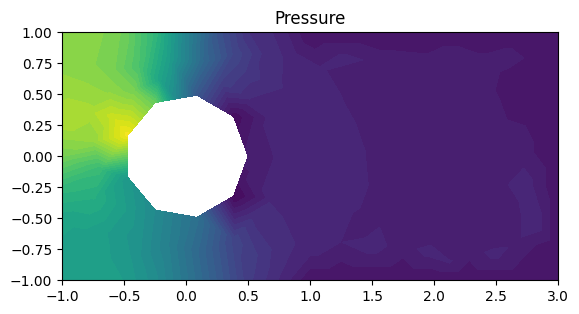

In [32]:
plot(u_sol, title="Velocity")
plt.figure()
plot(p_sol, title="Pressure")
plt.show()